In [2]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템
# model1 - LSTM l+ inear Dense ; target - sign((p(t+n) - p(t)) / p(t) * 100)
# model2 - tanh Dense 

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [3]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
import datetime

In [4]:
#tf.keras.backend.set_floatx('float64')

In [5]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
#    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')    
    #tf.config.experimental.set_virtual_device_configuration(
    #    gpus[1],
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [6]:
file_name = '~/Data/kospi200f_809_0403.csv'
item_name = 'kospi200f_reinfo_809'
train_start = '2000-01-31'
train_end = '2018-12-31'
test_start = '2019-01-02'
test_end = '2020-04-02'

remove_columns = ['date', '종가', '시가', '고가', '저가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'ddaeryuble3'
channel = False

trans_day = 2

target_alpha = 100
future_day = 1
n_timestep = 50
time_interval = 1
input_size = 809
n_unit = 800
batch_size = 50
learning_rate = 0.0005
epochs = 1000

alpha = 0.5
comment = ""

checkpoint_path = model_name + "/pred"+str(future_day)+"_trans"+str(trans_day)+".ckpt"

In [7]:
dataframe = util.read_datafile(file_name)
df = dataframe.copy()
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) / df.loc[i, target_column]) * target_alpha 

In [8]:
df['종가'].values[:20]

array([-3.55351171,  2.68747291,  0.67539046,  2.59958071, -0.89906007,
        1.56701031, -0.24360536, -1.62800163, -4.01323955, -4.43965517,
        3.15741994, -1.48666375, -0.71016423, -4.60438087,  0.51546392,
        3.07692308, -1.53776572,  0.04593477, -6.06060606,  0.63538612])

In [8]:
def loss_mean_square(model, input_data, output_data):
    logits = model(input_data, training=True)
    loss = tf.reduce_mean(tf.square(logits - output_data))
    return loss

In [9]:
"""
def loss_fn_(m, train_x, train_y):
    
    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))
    targets = train_y[:, n_timestep-1, 1:].reshape((-1))
    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))
    rates = (tagets - bse_prices) / base_prices
    updown = np.sign(targets - base_prices)
    preds = model(train_x)
    
    
    returns = [1.0]
    avg_return = 1.0
    avg_std = 0.0
    state = np.zeros((4))
    state[0] = 1.0 # average return
    state[1] = 0.0 # standard dev. of returns
    state[2] = 1.0
    state[3] = preds[train_x[0]]
    
    model2 = layers.Dense(units=10, activaton='tanh')
    
    #investment rate
    inv_r = np.zeros((len(train_y)))
    best_inv = np.zeros((len(train_y)))
    
    for i in range(len(targets)):
        state[0] = 
        state[1] = 
        state[2] = (len(train_y) - i) / len(train_y) 
        inv_r[i] = model2(state)
        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))
        
        r = tf.random.normal([100], mean=inv_r[i])
        sharp_ratio = np.zeros((len(r)))
        returns_random = [1.0]

        for j in range(len(r)):  
            returns_random.append(rates[i]*r[j] + 1-abs(r[j]))
            for k in range(i+1, len(train_y)):
                state[0] =
                state[1] = 
                state[2] = (len(train_y) - k) / len(train_y)
                inv_r[k] = model2(state, training=False)
                returns_random.append(rates[k]*inv_r[k] + 1-abs(inv_r[k]))
            avg_return = tf.math.reduce_prod(returns_random)**(1/(len(r)-i))
            std_return = tf.math.reduce_std(returns_random)
            sharp_ratio[j] = avg_return / std_return
        best_return_index = tf.math.argmax(sharp_ratio)
        best_inv[i] = r[best_return_index]

    return tf.math.square(inv_r - best_inv)
"""

"\ndef loss_fn_(m, train_x, train_y):\n    \n    #preds = m(train_x)[:, n_timestep-1, :-1].reshape((-1))\n    targets = train_y[:, n_timestep-1, 1:].reshape((-1))\n    base_prices = train_x[:, n_timestep-1, :-1].reshape((-1))\n    rates = (tagets - bse_prices) / base_prices\n    updown = np.sign(targets - base_prices)\n    preds = model(train_x)\n    \n    \n    returns = [1.0]\n    avg_return = 1.0\n    avg_std = 0.0\n    state = np.zeros((4))\n    state[0] = 1.0 # average return\n    state[1] = 0.0 # standard dev. of returns\n    state[2] = 1.0\n    state[3] = preds[train_x[0]]\n    \n    model2 = layers.Dense(units=10, activaton='tanh')\n    \n    #investment rate\n    inv_r = np.zeros((len(train_y)))\n    best_inv = np.zeros((len(train_y)))\n    \n    for i in range(len(targets)):\n        state[0] = \n        state[1] = \n        state[2] = (len(train_y) - i) / len(train_y) \n        inv_r[i] = model2(state)\n        returns.append(rates[i]*inv_r[i] + 1-abs(inv_r[i]))\n        \n 

In [10]:
def loss_fn_model1(m, train_x, train_y):
    
    targets = tf.math.sign(tf.reshape(train_y, [-1]))
    preds = tf.reshape(m(train_x), [-1])
        
    return tf.keras.losses.MSE(targets, preds)   

In [11]:
def loss_fn_model2(m1, m2, train_x, train_y):
    
    targets = tf.reshape(train_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(m1(train_x, training=False)[:, -1, 0], [-1])
    updown = tf.cast(tf.math.sign(preds), dtype=tf.float64)        
    profits = 1 + tf.convert_to_tensor(rates, dtype=tf.float64)*updown
    
    returns = [1.0]

    n = len(targets)
    for i in range(n):
       
        # average_return, std of returns, remaining days, preds[0] 
        state = []

        avg_return = tf.cast(tf.math.reduce_prod(returns)**(1/(i+1)), dtype=tf.float64)
        state.append(avg_return)
        state.append(tf.math.reduce_std(returns))
        state.append((n - i) / n)
        state.append(preds[i])
        state = np.array(state).reshape((1, 4))

        model2_pred = tf.math.abs(tf.cast(m2(state, training=True)[0, 0], dtype=tf.float64))
        returns.append(tf.math.multiply(profits[i], model2_pred) + 1-tf.math.abs(model2_pred))
        
    avg_return = tf.math.reduce_prod(returns)**(1/n)
    std_return = tf.math.reduce_std(returns)
    if std_return == 0: 
        sharp_ratio = avg_return
    else: 
        sharp_ratio = avg_return / std_return
    return -alpha*sharp_ratio

In [12]:
def test_model2(m1, m2, test_x, test_y):
    
    targets = tf.reshape(test_y[:, -1, 0], [-1])
    rates = targets / 100
    preds = tf.reshape(m1(test_x, training=False)[:, -1, 0], [-1])
    updown = tf.cast(tf.math.sign(preds), dtype=tf.float64)        
    profits = 1 + rates * updown
    
    returns = [1.0]
    inv_rate = []
    
    n = len(targets)
    for i in range(n):
        
        # average_return, std of returns, remaining days, preds[0] 
        state = np.zeros(4)
        
        state[0] = tf.cast(tf.math.reduce_prod(returns)**(1/(i+1)), dtype=tf.float64)
        state[1] = tf.math.reduce_std(returns)
        state[2] = (n - i) / n        
        state[3] = preds[i]
        state = state.reshape(1, 4)
        
        model2_pred = np.array(m2(state, training=False))[0, 0]
        inv_rate.append(model2_pred)
        returns.append(profits[i]*abs(tf.cast(model2_pred, dtype=tf.float64)) + 1-abs(tf.cast(model2_pred, dtype=tf.float64)))

    return inv_rate

In [13]:
def gradient(model, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model1(model, input_data, output_data)
    return tape.gradient(loss, model.trainable_variables)
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [14]:

#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
model1 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
model2 = models.DenseLayer(4, 10)

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

#    model.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
            
#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model.save_weights(checkpoint_path)
#model2.save_weights("modle2_"+ checkpoint_path)

In [15]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []
test_target = []

# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
early_stopping = learn.EarlyStopping(patience=2, verbose=1)

while True:

    gc.collect()
    
    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)
    
    # input_size, columns reset
    input_size = len(df.columns) - len(remove_columns)
    input_columns = df.columns.copy()

    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

    #model.compile(optimizer='adam',
    #          loss=loss_fn)
    #          #callbacks=[cp-callback]
    #          #metrics=['accuracy'])
    
    # the firs training dataset
    train_x = train_x[:-future_day]
    train_y = train_y[:-future_day]    
    
    #global_step = tf.train.get_or_create_global_step()
    global_step = tf.Variable(0, trainable=False)
    #lr_decay = tf.train.exponential_decay(learning_rate, global_step,
    #                                      train_input.shape[0]/batch_size*5, 0.5, staircase=True)
    lr_decay = tf.compat.v1.train.exponential_decay(learning_rate,global_step, int(len(train_y)/batch_size), 0.96, staircase=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    updown = np.sign(test_y[:, -1, 0]).reshape((-1))  
    iter = epochs
    basic_epochs = tf.cast(iter / 5, dtype=tf.int32)
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_interval_batch(train_x, train_y, batch_size, future_day)
        
        #noise = 2*np.random.randn(batch_size,n_timestep,1)
        #batch_output = batch_output+noise
        #batch_input = encoder(train_input[idx])
        gradients1 = gradient(model1, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
        gradients2 = gradient2(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))

        if iteration % 100 == 0:
            #test_MSE = model.evaluate(test_x, test_y)
            prediction = model1.predict(test_x)
            prediction_MSE = sum((updown - prediction[:, -1, 0]).reshape((-1))**2)/len(test_y)
            print('prediction_MSE =', prediction_MSE)

        if iteration > epochs / 2 and early_stopping.validate(prediction_MSE)==True:
            break
    if iter > basic_epochs: iter -= basic_epochs
    if iter < basic_epochs: iter = basic_epochs

    print('test dates ' + current_test_start + "~" + current_test_end)
    
    #단순 예측
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    prediction_MSE = sum(test_y[:, -1, 0] - prediction[:, -1, 0]).reshape((-1))**2/len(test_y)
    print('prediction_MSE =', prediction_MSE)

    #calculate accuracy
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('accuracy = ', accu)

    prediction2 = test_model2(model1, model2, test_x, test_y)    
    
    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)
    
    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_start = df.loc[prepro.date_to_index(df, current_train_start) + trans_day, 'date']
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for

prediction_MSE = 0.10224411343557449
prediction_MSE = 0.3180533318597504
prediction_MSE = 1.7175930452829746
prediction_MSE = 1.9503146377061302
prediction_MSE = 1.7983222296354349
prediction_MSE = 1.581186056494568
step :  5
Training process is stopped early....
test dates 2019-02-20~2019-02-21
prediction_MSE = [0.46075701]
accuracy =  tf.Tensor(0.5, shape=(), dtype=float64)
prediction_MSE = 1.9429163412120438
prediction_MSE = 0.12369937440281298
prediction_MSE = 3.400326070400057
prediction_MSE = 2.699812250560285
prediction_MSE = 1.9752940279453703
prediction_MSE = 3.3479374434089415
step :  6
Training process is stopped early....
test dates 2019-02-22~2019-02-25
prediction_MSE = [1.95853413]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 3.7865813762605924
prediction_MSE = 2.064281032682411
prediction_MSE = 2.1988554166245375
prediction_MSE = 3.4407649069305855
prediction_MSE = 3.5868827060080637
prediction_MSE = 3.6568039423651477
step :  7
Training process i

prediction_MSE = 1.8220710767601123
prediction_MSE = 0.4696004025652414
prediction_MSE = 1.2871611518122457
step :  11
Training process is stopped early....
test dates 2019-04-22~2019-04-23
prediction_MSE = [1.00501054]
accuracy =  tf.Tensor(0.5, shape=(), dtype=float64)
prediction_MSE = 1.830454213729782
prediction_MSE = 3.3943864892408175
prediction_MSE = 3.8086816589758232
prediction_MSE = 2.771094687532287
prediction_MSE = 3.4755117493182652
prediction_MSE = 3.946002297461293
step :  12
Training process is stopped early....
test dates 2019-04-24~2019-04-25
prediction_MSE = [5.48826502]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 3.9769498902893545
prediction_MSE = 3.9575640732498485
prediction_MSE = 3.3071376278829394
prediction_MSE = 3.87193570833867
prediction_MSE = 3.8583182265625258
prediction_MSE = 3.655436026176069
step :  13
Training process is stopped early....
test dates 2019-04-26~2019-04-29
prediction_MSE = [1.42924227]
accuracy =  tf.Tensor(0.0,

prediction_MSE = 1.764510048845878
prediction_MSE = 2.0661317583687353
prediction_MSE = 1.9992824540573384
prediction_MSE = 2.1969515616579063
prediction_MSE = 3.931398928239732
prediction_MSE = 3.842621613582546
step :  33
Training process is stopped early....
test dates 2019-06-26~2019-06-27
prediction_MSE = [5.9434263]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 1.5478179566486006e-05
prediction_MSE = 5.342598758772965e-05
prediction_MSE = 5.919087701755643e-06
prediction_MSE = 3.0962484721897e-05
prediction_MSE = 0.001556448770777763
prediction_MSE = 0.0005377443009315641
step :  34
Training process is stopped early....
test dates 2019-06-28~2019-07-01
prediction_MSE = [1.2194201]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 3.1061878173326996
prediction_MSE = 3.5544206710332578
prediction_MSE = 3.090493927992267
prediction_MSE = 2.8967171771840374
prediction_MSE = 3.366414778627245
prediction_MSE = 3.4852949872673253
step :  35
Trai

prediction_MSE = 2.040143245492972
step :  54
Training process is stopped early....
test dates 2019-08-26~2019-08-27
prediction_MSE = [0.30033952]
accuracy =  tf.Tensor(0.5, shape=(), dtype=float64)
prediction_MSE = 0.009366062299372757
prediction_MSE = 0.008275441989249899
prediction_MSE = 2.0121328027021406
prediction_MSE = 1.346264933895549
prediction_MSE = 1.4359702374590384
prediction_MSE = 2.0247785843255492
step :  55
Training process is stopped early....
test dates 2019-08-28~2019-08-29
prediction_MSE = [1.2396127]
accuracy =  tf.Tensor(0.5, shape=(), dtype=float64)
prediction_MSE = 0.00114579733470066
prediction_MSE = 0.00020820622997241856
prediction_MSE = 0.00032320104247673953
prediction_MSE = 9.791268108649831e-05
prediction_MSE = 7.279152240613485e-05
prediction_MSE = 9.429157609197603e-05
step :  56
Training process is stopped early....
test dates 2019-08-30~2019-09-02
prediction_MSE = [0.00224919]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.80

prediction_MSE = 0.3574543789140012
prediction_MSE = 1.055887470079059
prediction_MSE = 0.9614729461455149
prediction_MSE = 0.17114638055426923
prediction_MSE = 0.05097699459270366
prediction_MSE = 0.05579858824404482
step :  76
Training process is stopped early....
test dates 2019-10-31~2019-11-01
prediction_MSE = [0.07606029]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 3.7263737647494537
prediction_MSE = 3.5815211352237526
prediction_MSE = 3.9416107748163416
prediction_MSE = 3.832217833899655
prediction_MSE = 3.923504781758723
prediction_MSE = 3.742081261707094
step :  77
Training process is stopped early....
test dates 2019-11-04~2019-11-05
prediction_MSE = [7.80983677]
accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction_MSE = 1.9792140606550745
prediction_MSE = 1.9969532013069013
prediction_MSE = 1.995264584551144
prediction_MSE = 2.0037139160701773
prediction_MSE = 1.9725098599667774
prediction_MSE = 1.9994786364160895
step :  78
Training proces

prediction_MSE = 5.863993886023877e-06
prediction_MSE = 4.053427810291055e-06
prediction_MSE = 2.2059946491737037e-06
prediction_MSE = 5.933373746103143e-06
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2020-01-02~2020-01-03
prediction_MSE = [0.7878843]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.00011983560807493632
prediction_MSE = 2.5398145329091903e-05
prediction_MSE = 2.3110218764443857e-05
prediction_MSE = 0.0010647752726811177
prediction_MSE = 0.001318906585057178
prediction_MSE = 0.0014319128753772503
step :  4
Training process is stopped early....
test dates 2020-01-06~2020-01-07
prediction_MSE = [0.07117386]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 2.004194663240968
prediction_MSE = 2.007497317247031
prediction_MSE = 1.982310844747504
prediction_MSE = 1.9775503248566828
prediction_MSE = 1.9660171582314945
prediction_MSE = 2.0010761887024913
step :  5
Training process is stopped early....
t

prediction_MSE = 0.0007326756295018555
prediction_MSE = 0.0009002186472617524
prediction_MSE = 0.000832680597980584
prediction_MSE = 0.006919606673408296
step :  4
Training process is stopped early....
test dates 2020-03-04~2020-03-05
prediction_MSE = [0.96856678]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 0.8957772337226189
prediction_MSE = 0.02002585516145139
prediction_MSE = 0.004052903850032763
prediction_MSE = 0.019217804233479185
prediction_MSE = 1.249742232545259e-05
prediction_MSE = 1.9433383506850532e-05
step :  5
Training process is stopped early....
test dates 2020-03-06~2020-03-09
prediction_MSE = [11.83909257]
accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction_MSE = 1.964903212276468
prediction_MSE = 1.9694131296597348
prediction_MSE = 1.973442146149015
prediction_MSE = 1.9954386860559232
prediction_MSE = 1.957910898389322
prediction_MSE = 2.0058523870264366
step :  6
Training process is stopped early....
test dates 2020-03-10~2020-03-

In [16]:
t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

In [9]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)

# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [18]:
updown = np.sign(test_y[:, -1, 0]).reshape((-1))
#calculate accuracy
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('accuracy = ', accu)

accuracy =  tf.Tensor(0.5290322580645161, shape=(), dtype=float64)


In [19]:
#train_base_prices = train_base_prices[:batch_size]
#train_prediction = train_prediction[:batch_size]
#train_y = train_y[:batch_size]

In [20]:
gc.collect()
import learn
from learn import GenerateResult
result = GenerateResult(t1, t2, test_y[:, -1, 0].reshape(-1), test_dates, n_timestep, future_day, trans_day)

In [21]:
#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

info : ddaeryuble3_kospi200f_reinfo_809_1_50_1_0.535
MSE : 3.2561 , Accuracy : 0.535
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ddaeryuble3_kospi200f_reinfo_809_1_50_1_0.535/assets


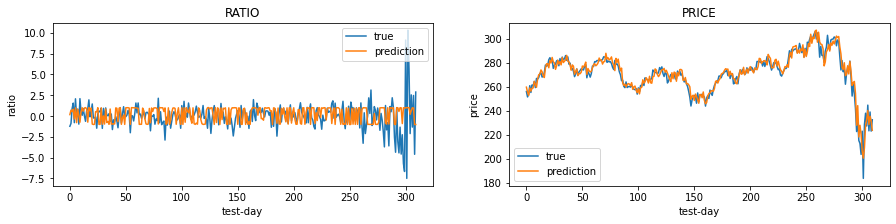

In [22]:
result.evaluation()
result.table()
result.save_result(model_name,item_name,n_unit,target_type,batch_size,n_timestep,time_interval,epochs,str(alpha),comment)
result.save_visualization()
result.save_model(model2)

In [23]:
    """
    # 변동성 학습
    prediction = learn.predict_batch_test(model, test_x, len(test_x))[:, -1, -1].reshape((-1))
    real = tf.cast(test_y[:, -1, -1].reshape((-1)), tf.float32)
    v_model = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
    optimizer = tf.keras.optimizers.Adam()
    for i in range(20):
        with tf.GradientTape() as tape:
            v_loss = models.loss_prediction_interval(v_model, test_x, prediction, real)
        gradients = tape.gradient(v_loss, v_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, v_model.trainable_variables))
    cnt = 0
    std = tf.reshape(v_model(test_x, training=False)[:, -1, -1], [-1])
    for i in range(len(real)):
        if real[i] > prediction[i] - 1.96 * std[i] and real[i] < prediction[i] + 1.96 * std[i]:
                   cnt += 1
      
    #test_prediction.append(learn.predict_batch_test(model, test_x, len(test_x))) 
    if first_trans:
        test_prediction = prediction
        test_target = test_y
    else:
        test_prediction = np.concatenate([test_prediction, prediction], axis=0)
        test_target = np.concatenate([test_target, test_y], axis=0)
    first_trans = False
    
    test_prediction_x = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
    test_target_y = np.concatenate(test_target, axis=0).reshape((-1, n_timestep, 1))
    
    expected_diff = tf.math.reduce_mean(test_target_y - test_prediction_x)
    #std_diff = tf.math.reduce_std(test_target_y - test_prediction_x)
    std_diff = 1.6
    
    test_prediction = np.a
    """

'\n# 변동성 학습\nprediction = learn.predict_batch_test(model, test_x, len(test_x))[:, -1, -1].reshape((-1))\nreal = tf.cast(test_y[:, -1, -1].reshape((-1)), tf.float32)\nv_model = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)\noptimizer = tf.keras.optimizers.Adam()\nfor i in range(20):\n    with tf.GradientTape() as tape:\n        v_loss = models.loss_prediction_interval(v_model, test_x, prediction, real)\n    gradients = tape.gradient(v_loss, v_model.trainable_variables)\n    optimizer.apply_gradients(zip(gradients, v_model.trainable_variables))\ncnt = 0\nstd = tf.reshape(v_model(test_x, training=False)[:, -1, -1], [-1])\nfor i in range(len(real)):\n    if real[i] > prediction[i] - 1.96 * std[i] and real[i] < prediction[i] + 1.96 * std[i]:\n               cnt += 1\n  \n#test_prediction.append(learn.predict_batch_test(model, test_x, len(test_x))) \nif first_trans:\n    test_prediction = prediction\n    test_target = test_y\nelse:\n    test_prediction = np.